In [1]:
import cv2
import json
import pprint
import numpy as np
import scipy.sparse
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def img_shrink(img_url, MAX_DIM=1024, show=0):
    img = skimage.io.imread(img_url)
    (h,w) = img.shape
    img_aspect = max(h,w) / min(h,w)
    MIN_DIM = MAX_DIM / img_aspect
    img_trans = skimage.transform.resize(img, (MIN_DIM, MAX_DIM), preserve_range=True)
    img_trans = np.array(img_trans, dtype=np.uint16)
    if show:
        f,axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img)
        axarr[1].imshow(img_trans)
    return img_trans

def convert_mapillary_to_cityscapes(mapillary_image_url, mapillary_to_cityscapes_mapping_url, mapillary_binarymap_save_url
                                        , format_img, class_id_study = None
                                        , verbose=0, show = 0):
    ## 1. IMAGE READ
    mapillary_image_name = mapillary_image_url.split('.png')[0].split('/')[2]
    img_int16 = skimage.io.imread(mapillary_image_url)
    # img_int16 = img_shrink(mapillary_image_url)
    img_int8  = cv2.imread(mapillary_image_url)
    (w, h) = img_int16.shape
    class_ids = np.unique(img_int8)
    class_instance_ids = np.unique(img_int16)
    
    ## 2. IMAGE SHOW
    if verbose:
        print ('Shape : ', img_int16.shape)
        print ('Classes : ', class_ids)
        print ('Classes_Instances : ', class_instance_ids)
    if show:
        f, axarr = plt.subplots(1,2, figsize = (10,10))
        axarr[0].imshow(img_int8, cmap = 'gray')
        axarr[1].imshow(img_int16, cmap = 'gray')
    
    ## 3. MAPPING(MAPI -> CITY) READ
    # scp merge__cityscapes_mapillary_v1.json playment-gpu:/home/play/playment/production/Mask_RCNN/demo/raw
    with open(mapillary_to_cityscapes_mapping_url, 'r') as fp:
        converter_json = json.load(fp)
        if class_id_study != None:
            print ('Class_Study : {0} : {1}'.format(class_id_study, converter_json['mapillary_class'][str(class_id_study)]['cityscapes_label']))
    
    
    ## 4. MAPPING INT8->INT16
    class_ids_mapping_16_8 = {class_id : [] for class_id in class_ids}
    for class_instance_id in class_instance_ids:
        for class_id in class_ids_mapping_16_8:
            class_floor, class_cieling = class_id*256, (class_id + 1)*256
            if class_instance_id >= class_id*256 and class_instance_id < (class_id + 1)*256:
                class_ids_mapping_16_8[class_id].append(class_instance_id)
    # pprint.pprint(class_ids_mapping_16_8)
    
    if format_img == '.npz':
        res = {}
    
    ## 5. EXTRACTING INDIVIDUAL MASKS
    masks_res = []
    class_ids_res = []
    for class_id_int8 in sorted(class_ids_mapping_16_8):
        if class_id_study != None and class_id_study != class_id_int8:
            continue
        if class_id_study == class_id_int8:
            class_id_study_instances = len(class_ids_mapping_16_8[class_id_study])
            print (' --> Total instances : ', class_id_study_instances)
            if show:
                f, axarr = plt.subplots(1, class_id_study_instances, figsize=(15,15))
        
        for inst_id, class_id_int16 in enumerate(sorted(class_ids_mapping_16_8[class_id_int8])):
            tmp = np.zeros((img_int16.shape), dtype=np.uint8)
            tmp[img_int16 != int(class_id_int16)] = 0
            tmp[img_int16 == int(class_id_int16)] = 1
            # tmp = np.packbits(tmp, axis=None)
            tmp = scipy.sparse.csc_matrix(tmp)
            # print (tmp2.data.nbytes, tmp2.indptr.nbytes, tmp2.indices.nbytes)            
            
            class_id_cityscapes = converter_json['mapillary_class'][str(class_id_int8)]['cityscapes_class']
            tmp_name = '{0}'.format(inst_id + 1)
            if format_img != '.npz': 
                save_url = '{0}/{1}.png'.format(mapillary_binarymap_save_url, tmp_name)
                cv2.imwrite(save_url,tmp)
                if show and class_id_study != None:
                    axarr[inst_id].imshow(tmp, cmap = 'gray')
            
            else:
                if str(class_id_cityscapes) not in res:
                    res[str(class_id_cityscapes)] = {}                
                res[str(class_id_cityscapes)][tmp_name] = tmp
                
    if format_img == '.npz':
        np.savez('{0}/{1}.npz'.format(mapillary_binarymap_save_url, mapillary_image_name) , **res)
                 
    if show:
        pass
    
    pprint.pprint(res)
    return res

if __name__ == "__main__":
    mapillary_image_url = './data/_1AbvbARvB-5S0rAPN02Mg.png'
    mapillary_to_cityscapes_mapping_url = './merge__cityscapes_mapillary_v1.json'
    mapillary_binarymap_save_url = './data'
    
    res = convert_mapillary_to_cityscapes(mapillary_image_url, mapillary_to_cityscapes_mapping_url, mapillary_binarymap_save_url
                                    ,format_img = '.npz', class_id_study=None, show = 0, verbose=0)

{2: [512],
 13: [3328],
 15: [3840],
 17: [4352],
 19: [4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871],
 21: [5376],
 24: [6144],
 25: [6400],
 27: [6912],
 30: [7680],
 35: [8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967],
 39: [9984, 9985],
 44: [11264],
 45: [11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529],
 46: [11776],
 47: [12032,
      12033,
      12034,
      12035,
      12036,
      12037,
      12038,
      12039,
      12040,
      12041,
      12042,
      12043,
      12044,
      12045,
      12046,
      12047,
      12048,
      12049,
      12050,
      12051,
      12052,
      12053,
      12054,
      12055,
      12056,
      12057,
      12058,
      12059],
 48: [12288],
 50: [12800, 12801],
 54: [13824],
 55: [14080,
      14081,
      14082,
      14083,
      14084,
      14085,
      14086,
      14087,
      14088,
      14089,
      14090,
      14091],
 57: [14592, 14593],
 61: [15616],
 62: [15872],
 65: [16640]}


# SCRATCHPAD

In [ ]:
import json
import numpy as np

with open('./merge__cityscapes_mapillary_v1.json', 'r') as fp:
    converter_json = json.load(fp)
    city_class = []
    for class_id in converter_json['mapillary_class']:
        city_class.append(converter_json['mapillary_class'][class_id]['cityscapes_class'])

    print (np.unique(city_class))

(2988, 3984) [512, 3328, 3840, 4352, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 5376, 6144, 6400, 6912, 7680, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 9984, 9985, 11264, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11776, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12288, 12800, 12801, 13824, 14080, 14081, 14082, 14083, 14084, 14085, 14086, 14087, 14088, 14089, 14090, 14091, 14592, 14593, 15616, 15872, 16640]
(768, 1024) [512, 522, 523, 534, 538, 541, 545, 547, 567, 570, 571, 573, 576, 588, 590, 599, 600, 610, 621, 622, 623, 637, 638, 642, 656, 662, 666, 669, 672, 674, 678, 684, 691, 698, 710, 711, 722, 736, 746, 753, 754, 766, 768, 777, 778, 782, 784, 796, 797, 798, 801, 807, 823, 826, 839, 842, 850, 851, 887, 894, 899, 900, 902, 903, 905, 908, 915, 919, 934, 954, 963, 980, 999, 1006, 1008, 1014, 10

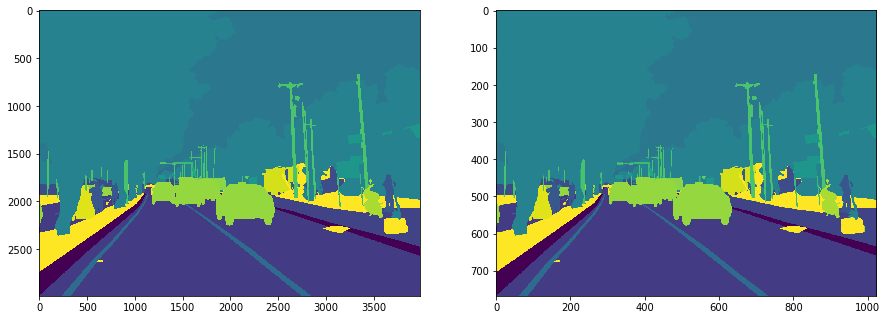

In [19]:
def img_shrink(img_url, MAX_DIM=1024, show=0):
    img = skimage.io.imread(img_url)
    print (img.shape, list(np.unique(img)))
    (h,w) = img.shape
    img_aspect = max(h,w) / min(h,w)
    MIN_DIM = MAX_DIM / img_aspect
    img_trans = skimage.transform.resize(img, (MIN_DIM, MAX_DIM), preserve_range=True, mode='reflect')
    img_trans = np.array(img_trans, dtype = np.uint16)
    print (img_trans.shape, list(np.unique(img_trans)))
    
    if show:
        f,axarr = plt.subplots(1,2, figsize=(15,15))
        axarr[0].imshow(img)
        axarr[1].imshow(img_trans)
    return img_trans

mapillary_image_url = './data/_1AbvbARvB-5S0rAPN02Mg.png'
img_trans = img_shrink(mapillary_image_url, show=1)

In [22]:
masks_res     = []
class_ids_res = []
masks_sparse = np.load('./data/_1AbvbARvB-5S0rAPN02Mg.npz')
for class_id in masks_sparse:
    for instance_id in masks_sparse[class_id].item():
        mask_class_instance = np.array(masks_sparse[class_id].item()[instance_id].todense())
        masks_res.append(mask_class_instance)
        class_ids_res.append(class_id)

print (len(class_ids_res))

63


In [ ]:
for mask in masks_res:
    _, contours, hierarchy = cv2.findContours(masks[idx], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)